# Gradient Class Activation Map

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from pocovidnet.evaluate_covid19 import Evaluator
from pocovidnet.grad_cam import GradCAM
from pocovidnet.cam import get_class_activation_map
from pocovidnet.model import get_vgg16_model

In [2]:
def convolve_faster(img, kernel):
    """
    Convolve a 2d img with a kernel, storing the output in the cell
    corresponding the the left or right upper corner
    :param img: 2d numpy array
    :param kernel: kernel (must have equal size and width)
    :param neg: if neg=0, store in upper left corner, if neg=1,
    store in upper right corner
    :return convolved image of same size
    """
    k_size = len(kernel)
    # a = np.pad(img, ((0, k_size-1), (0, k_size-1)))
    padded = np.pad(img, ((k_size//2, k_size//2), (k_size//2, k_size//2)))

    s = kernel.shape + tuple(np.subtract(padded.shape, kernel.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(padded, shape=s, strides=padded.strides * 2)
    return np.einsum('ij,ijkl->kl', kernel, subM)

In [5]:
path_crossval = "./image_cross_val"
weights_dir = "./trained_models/model_0"
gt_dict = {"Reg":2, "Pne":1, "pne":1, "Cov":0}

gradcam = GradCAM()

all_predictions = []
heatmap_points, predicted, gt_class, overlays, fnames = [], [], [], [], []

for fold in range(5):
    # load weights of the respective fold model
    print("NEW FOLD", fold)
    # make sure the variable is cleared
    evaluator = None
    # load weights
    evaluator = Evaluator(weights_dir="./trained_models/model_16/val", ensemble=False, split=fold, model_id="vgg_16", num_classes=3)
    # get all names belonging to this fold
    all_images_arr = []
    gt, name = [], []
    for mod in ["covid", "pneumonia", "regular"]:
        for f in os.listdir(os.path.join(path_crossval, "split"+str(fold), mod)):
            if f[0]!=".":
                img_loaded = cv2.imread(os.path.join(path_crossval, "split"+str(fold), mod, f))
                img_preprocc = evaluator.preprocess(img_loaded)[0]
                gt.append(gt_dict[f[:3]])
                all_images_arr.append(img_preprocc)
                name.append(f)
    all_images_arr = np.array(all_images_arr)
    # predicciones
    print("process all images in fold", fold, "with shape", all_images_arr.shape)
    fold_preds = evaluator.models[0].predict(all_images_arr)
    class_idx_per_img = np.argmax(fold_preds, axis=1)
    all_predictions.append(fold_preds)
    
    # heatmap 
    for i, img in enumerate(all_images_arr):
        overlay, heatmap = gradcam.explain(img, evaluator.models[0], gt[i], return_map=True, image_weight=1, layer_name="block5_conv3", zeroing=0.65, heatmap_weight=0.25)     
       
        overlays.append(overlay.astype(int))
        # convolve with big kernel
        convolved_overlay = convolve_faster(heatmap, np.ones((19,19)))
        x_coord, y_coord = divmod(np.argmax(convolved_overlay.flatten()), len(convolved_overlay[0]))
        
        heatmap_points.append([x_coord, y_coord])
        predicted.append(class_idx_per_img[i])
        gt_class.append(gt[i])
        fnames.append(name[i])  

NEW FOLD 0
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
process all images in fold 0 with shape (269, 224, 224, 3)
NEW FOLD 1
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
process all images in fold 1 with shape (350, 224, 224, 3)
NEW FOLD 2
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
process all images in fold 2 with shape (231, 224, 224, 3)
NEW FOLD 3
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
process all images in fold 3 with shape (305, 224, 224, 3)
NEW FOLD 4
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
process all images in fold 4 with shape (234, 224, 224, 3)


<Figure size 1080x864 with 0 Axes>

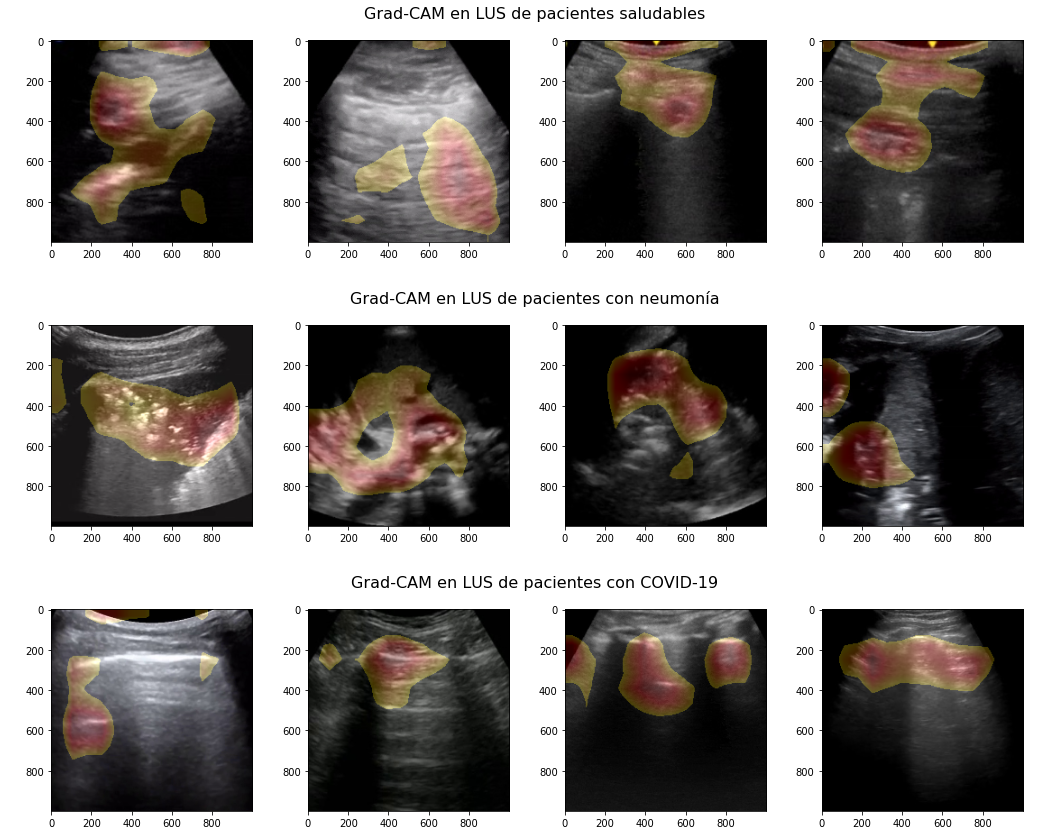

In [233]:
import numpy as np
import matplotlib.pyplot as plt

w=12
h=15
fig=plt.figure(figsize=(15, 12))
#fig.tight_layout(h_pad=20)
columns = 4
rows = 3
item_img = [overlays[4], overlays[7], overlays[16], overlays[97],
            overlays[778], overlays[1041], overlays[1061], overlays[1333],
            overlays[819], overlays[849], overlays[843], overlays[1075]]

item_img_fp = []

fig, big_axes = plt.subplots(figsize=(15, 12), nrows=3, ncols=1, sharey=True)
classes_sp=['saludables', 'con neumonía', 'con COVID-19']
for idx, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Grad-CAM en LUS de pacientes %s \n\n\n" % classes_sp[idx - 1], fontsize=16, pad=-30)
    big_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    
    big_ax._frameon = False
for i in range(1, columns*rows +1):
    img = item_img[i-1]
    fig.add_subplot(rows, columns, i)
    fig.tight_layout(h_pad=1)
    plt.imshow(img)
           
plt.show()

fig.savefig("grad-cam-img.pdf",bbox_inches='tight')